# Classificação Quesitonário Socio-econômico (SAEP 2011)

# Importando Bibliotecas

### Computação Científica

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

### Machine Learning: Classificação

In [5]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as TREE, DecisionTreeRegressor as TREE_reg
from sklearn.linear_model import LogisticRegression as LogReg, SGDClassifier as SGDC
from sklearn.svm import SVC, SVR

from sklearn.ensemble import BaggingClassifier as BGG, RandomForestClassifier as RFC, ExtraTreesClassifier as ETC, StackingClassifier as STCK, GradientBoostingClassifier as GBC, AdaBoostClassifier as ABC, VotingClassifier as Voting
from sklearn.ensemble import BaggingRegressor as BGG_reg, RandomForestRegressor as RFR, ExtraTreesRegressor as ETR, AdaBoostRegressor as ABR

from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit as sss, train_test_split

from sklearn.metrics import accuracy_score as acc_scr, r2_score, classification_report as cr, confusion_matrix as cm, make_scorer
scorer = make_scorer(acc_scr)

from sklearn.preprocessing import LabelEncoder as le

In [3]:
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms

# Carregando Dados

In [547]:
ano5 = pd.read_csv('questionario_aluno_quinto_ano_limpo.csv')
ano9 = pd.read_csv('questionario_aluno_nono_ano_limpo.csv')
ano3 = pd.read_csv('questionario_aluno_terceiro_ano_limpo.csv')

In [1621]:
ano5_merged = pd.read_csv('quest_aluno_escola_5ano.csv')
ano9_merged = pd.read_csv('quest_aluno_escola_9ano.csv')
ano3_merged = pd.read_csv('quest_aluno_escola_3ano.csv')    

In [1622]:
anos = [ano5, ano9, ano3]
anos_mrg = [ano5_merged, ano9_merged, ano3_merged]

In [1623]:
[ano.shape for ano in anos], [ano.shape for ano in anos_mrg]

([(468706, 69), (360455, 73), (20117, 77)],
 [(468706, 131), (360455, 135), (20117, 139)])

In [5]:
dict_5ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 5ano.csv').set_index('questão')
dict_9ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 9ano.csv').set_index('questão')
dict_3ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 3ano.csv').set_index('questão')

## Setting Models

In [1715]:
simple_models = [KNN(), TREE(), LogReg(), SVC(), SGDC()]
ensemble_models = [BGG(), RFC(), ETC(), ABC(), GBC()]
regressors = [TREE_reg(),BGG_reg(), RFR(), ETR(), ABR()]
feat_imp_models = [TREE, RFC, ETC, GBC, ABC]

simple_names = ['KNN', 'TREE', 'LogReg', 'SVC', 'SGDC']
ensemble_names = ['BGG', 'RFC', 'ETC', 'ABC', 'GBC']
reg_names = ['TREE_reg', 'BGG_reg', 'RFR', 'ETR', 'ABR']
feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC']

bootstrap_models = [ETC(bootstrap=True)]

In [8]:
votings = [Voting([(simple_names[i], simple_models[i]) for i in range(5)]),
           Voting([(ensemble_names[i], ensemble_models[i]) for i in range(5)]),
           STCK([(simple_names[i], simple_models[i]) for i in range(5)]),
           STCK([(ensemble_names[i], ensemble_models[i]) for i in range(5)])
          ]

votings_names = ['simple_voting', 'ensemble_voting', 'simple_stacking', 'ensemble_stacking']

In [9]:
models = simple_models + ensemble_models# + votings
models_names = simple_names + ensemble_names# + votings_names

## Function to Score Multiple Models

### Function

In [478]:
def score_models(df, target, models, models_names, test_size, random_state=1, clear=True, retraining=None):

    feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC']
    
    print('Extraindo variáveis independentes e variável dependente...')
    
    y = df[target].copy()
    x = df.drop(target, axis=1).copy()
    
    print('Dividindo amostras de teste e de treinamento...')

#    if type(msk)==type(None): msk = np.random.rand(len(y))<(1-test_size)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
#---------------

    n_models = len(models_names)
    scrs = []
    for i in range(n_models):
        
        if clear: clear_output(wait=True)
        print('Model {} ({}/{}) Fitting...'.format(models_names[i], i+1, n_models))
        fitted_model =  models[i].fit(x_train, y_train)

        print('Predicting...'.format(models_names[i], i+1, n_models))        
        y_pred = fitted_model.predict(x_test)
        
        print('Scoring...'.format(models_names[i], i+1, n_models))
        #return y_pred.astype(int), y_test
        scr = acc_scr(y_test, y_pred.astype(int))
       
        scrs.append(scr)
        
    scrs_df = pd.DataFrame(scrs, columns=['acc'], index=models_names)
    
    if type(retraining)!=type(None): scrs_df = pd.concat([retraining, scrs_df], axis=0)
    return scrs_df


In [459]:
scrs_df

,acc
2070,0.707729
2070,0.714976
2070,0.710145
4140,0.725845
4140,0.735507
...,...
41400,0.747343
41400,0.747101
ETC,0.745773
ETC,0.740821


### Definindo Colunas Alvo

In [11]:
targets_names = ['Sexo', 'Auto Declaração', 'Trabalho Doméstico', 'Trabalho Fora de Casa', 'Reprovado', 'Abandono']

#### 5° Ano

In [12]:
targets_5ano = ['TX_RESP_Q001', 'TX_RESP_Q002', 'TX_RESP_Q044', 'TX_RESP_Q045', 'TX_RESP_Q048', 'TX_RESP_Q049']
i=-1

### 9° Ano

In [13]:
targets_9ano = ['TX_RESP_Q001', 'TX_RESP_Q002', 'TX_RESP_Q045', 'TX_RESP_Q046', 'TX_RESP_Q049', 'TX_RESP_Q050', 'TX_RESP_Q058']
targets_names_9ano = ['Sexo', 'Auto Declaração', 'Trabalho Doméstico', 'Trabalho Fora de Casa', 'Reprovado', 'Abandono', 'Pretende']
i=-1

#### 3° Ano

In [14]:
targets_3ano = ['TX_RESP_Q001', 'TX_RESP_Q002', 'TX_RESP_Q039', 'TX_RESP_Q040', 'TX_RESP_Q043', 'TX_RESP_Q044']
i=-1

# E Agora?

In [15]:
dict_9ano.loc[targets_9ano[-1]]

Enunciado    Quando você terminar o 9º ano(8ª série), você ...
A                                 Somente continuar estudando.
B                                           Somente Trabalhar.
C                             Continuar estudando e trabalhar.
D                                               Ainda não sei.
E                                                          NaN
F                                                          NaN
G                                                          NaN
H                                                          NaN
I                                                          NaN
J                                                          NaN
K                                                          NaN
L                                                          NaN
Name: TX_RESP_Q058, dtype: object

# Rotulando Variáveis Categóricas

In [1815]:
out_cols = ['ID_SAEB', 'IN_SITUACAO_CENSO', 'IN_PROVA_BRASIL', 'IN_PREENCHIMENTO', 'ID_ALUNO']

In [1816]:
ano9_cat = ano9.drop(out_cols, axis=1)
ano9_cat.replace(np.nan, 'Z',inplace=True)
ano9_cat = ano9_cat.astype(str)

for col in ano9_cat:
    ano9_cat[col] =le().fit(ano9_cat[col]).transform(ano9_cat[col])

In [1817]:
ano9_cat_mrg = ano9_merged.copy()
ano9_cat_mrg.replace(np.nan, 'Z',inplace=True)
ano9_cat_mrg = ano9_cat_mrg.astype(str)

for col in ano9_cat_mrg:
    ano9_cat_mrg[col] =le().fit(ano9_cat_mrg[col]).transform(ano9_cat_mrg[col])

# Definindo x e y (Variável álvo)

In [1818]:
target = targets_9ano[5]

In [1819]:
targets_names_9ano[5]

'Abandono'

In [1828]:
y = ano9_cat[target].copy()
#x = ano9_cat.drop(target, axis=1)

In [1829]:
y_mrg = ano9_cat_mrg[target].copy()
#x = ano9_cat.drop(target, axis=1)

# Ajustando Proporção entre Categorias

In [1832]:
y.value_counts()

0    326989
1     21818
2      6401
3      5247
Name: TX_RESP_Q050, dtype: int64

In [1833]:
y_list = [y[y==0].sample(20000),
          y[y==1].sample(15000),
         # y[y==2].sample(9000),
       #   y[y==5].sample(9000),
        #  y[y==3].sample(9000),
          y[y.isin([2])]]


prop_index = pd.concat(y_list, axis=0).index

ano9_prop = ano9_cat.loc[prop_index].reset_index(drop=True)

ano9_prop[target].value_counts()

0    20000
1    15000
2     6401
Name: TX_RESP_Q050, dtype: int64

In [1834]:
y_mrg.value_counts()

0    326989
1     21818
2      6401
3      5247
Name: TX_RESP_Q050, dtype: int64

In [1835]:
ano9_prop_mrg = ano9_cat_mrg.loc[prop_index].reset_index(drop=True)
ano9_prop_mrg[target].value_counts()

0    20000
1    15000
2     6401
Name: TX_RESP_Q050, dtype: int64

### Eliminando Categrias

In [564]:
ano9_prop = ano9_prop[ano9_prop[target]!=3]

### Unindo Categorias

In [1836]:
ano9_prop[target].replace(2,1, inplace=True)

ano9_prop[target].value_counts()

1    21401
0    20000
Name: TX_RESP_Q050, dtype: int64

In [1837]:
ano9_prop_mrg[target].replace(2,1, inplace=True)

ano9_prop_mrg[target].value_counts()

1    21401
0    20000
Name: TX_RESP_Q050, dtype: int64

### Versão "Lite"

In [1840]:
ano9_lite = ano9_prop.sample(10000)

ano9_mrg_lite = ano9_prop_mrg.loc[ano9_lite.index]

In [1842]:
anos_lite = [ano9_lite, ano9_mrg_lite]

[ano.shape for ano in anos_lite]

# Chamando Função para Avaliar Modelos

In [1844]:
scrs = score_models(anos_lite[0], target, simple_models[:3]+ensemble_models[:4], simple_names[:3]+ensemble_names[:4], 0.2)

Model ABC (7/7) Fitting...
Predicting...
Scoring...


In [1845]:
scrs_mrg = score_models(anos_lite[1], target, simple_models[:3]+ensemble_models[:4], simple_names[:3]+ensemble_names[:4], 0.2)

Model ABC (7/7) Fitting...
Predicting...
Scoring...


In [1846]:
scrs

,acc
KNN,0.5300
TREE,0.6955
LogReg,0.7420
BGG,0.7155
RFC,0.7610
ETC,0.7515
ABC,0.7505


In [1847]:
scrs_mrg

,acc
KNN,0.5280
TREE,0.6625
LogReg,0.5215
BGG,0.7280
RFC,0.7590
ETC,0.7320
ABC,0.7530


### Voting

In [60]:
scr_voting_ensemble = score_models(ano9_prop, target, votings[1:2], votings_names[1:2], 0.2)

scr_stacking_ensemble = score_models(ano9_prop, target, votings[3:], votings_names[3:], 0.2)

In [59]:
scr_voting_ensemble

,acc
ensemble_voting,0.762146


In [61]:
scr_stacking_ensemble

,acc
ensemble_stacking,0.758381


# Optimização

In [63]:

models = ensemble_models[2:]

In [64]:
names = ensemble_names[2:]

### Modelo Simples

In [1669]:
y = ano9_prop[target]
x = ano9_prop.drop([target], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=4)

abc = ABC(random_state=4).fit(x,y)
y_pred = abc.predict(x_test)
acc = acc_scr(y_test, y_pred)

acc_samme

0.752203840115928

In [1668]:
y_mrg = ano9_prop_mrg[target]
x_mrg = ano9_prop_mrg.drop([target], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_mrg, y_mrg, test_size=0.2, random_state=4)

abc = ABC(random_state=4).fit(x_mrg, y_mrg)
y_pred = abc.predict(x_test)
acc = acc_scr(y_test, y_pred)

acc_samme

0.752203840115928

### Comparing Datasets

In [1862]:
def feat_imp(df, target, test_size=0.2, random_state=None):

    feat_imp_models = [TREE, RFC, ETC, GBC, ABC]
    feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC']
    
    y = df[target].copy()
    x = df.drop([target], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1-test_size), random_state=random_state)

    feat_cols = x_train.columns.tolist()
    scrs = []
    lst = []
    for i in range(len(feat_imp_models)):

        print('({}/{}) {}'.format(i, len(feat_imp_names), feat_imp_names[i]))
        print('Fitting...')
        model = feat_imp_models[i]().fit(x_train, y_train)
        print('Predicting...')
        y_pred = model.predict(x_test)
        print('Scoring...')
        acc = acc_scr(y_test, y_pred)

        feat_imps = model.feature_importances_.tolist()
        lst.append([feat_imp_names[i]]+feat_imps)
        scrs.append([feat_imp_names[i], acc])

        clear_output(wait=True)

    scrs_df = pd.DataFrame(scrs, columns=['model_name', 'acc']).set_index('model_name')
    feat_df = pd.DataFrame(lst, columns=['model_name'] + feat_cols).set_index('model_name')

    return scrs_df, feat_df

In [1863]:
scrs_feat, imps = feat_imp(anos_lite[0], target, random_state=4)

(4/5) ABC
Fitting...
Predicting...
Scoring...


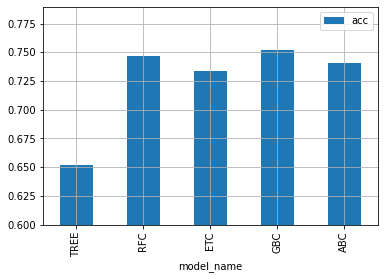

In [1864]:
scrs_feat.plot.bar(x='model_name', ylim=(0.6))
plt.grid()

In [1884]:
ss_acc.transform([scrs_feat.loc[name]])[0][0]

-1.9717453371506937

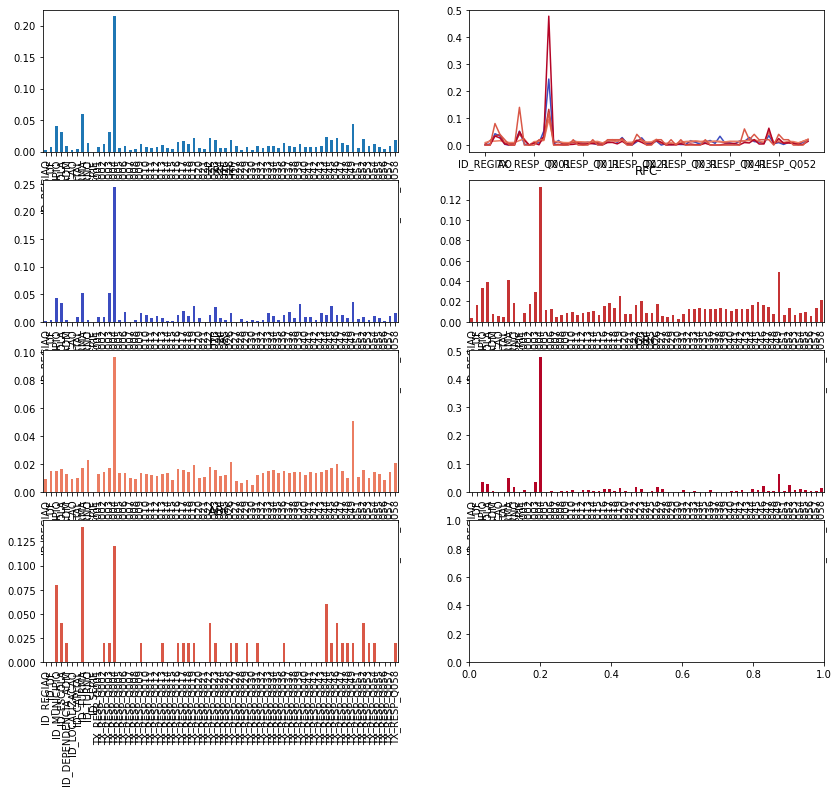

In [1895]:
mms_acc = mms().fit(scrs_feat)

fig, axs = plt.subplots(4, 2, figsize=(14,12))

imps.mean(axis=0).plot.bar(ax=axs[0][0])
ind1, ind2 = [1,1,2,2,3], [0,1,0,1,0]

for i, name in enumerate(imps['model_name']):
    color = cmap(mms_acc.transform([scrs_feat.loc[name]])[0][0])
    
    imps.set_index('model_name').loc[name].plot(ax=axs[0][1], color=color)
    imps.set_index('model_name').loc[name].plot.bar(ax=axs[ind1[i]][ind2[i]], color=color)
    axs[ind1[i]][ind2[i]].set_title(name)

### Extraindo top 10 variáveis independentes mais importantes de cada modelo

In [1779]:
top_10 = [feat_df.set_index('model_name').loc[name].sort_values(ascending=False).head(15).index.tolist() for name in feat_df.model_name]

top_10_feats = np.unique(top_10).tolist()

top10_df = anos_lite[1][top_10_feats+[target]]

### Avaliando Modelo com 30 variáveis mais importantes

In [1780]:
top10_scrs = score_models(top10_df, target, simple_models[:3]+ensemble_models[:4], simple_names[:3]+ensemble_names[:4], test_size=0.2, random_state=4)

Model ABC (7/7) Fitting...
Predicting...
Scoring...


In [1781]:
top10_scrs

,acc
KNN,0.4995
TREE,0.6520
LogReg,0.5625
BGG,0.7205
RFC,0.7495
ETC,0.7455
ABC,0.7535


In [1788]:
n_est_i = range(3,100,10)
l_r_i = np.linspace(0.001,3,10)

In [1789]:
top10_params = [{'n_estimators':n_est, 'learning_rate':l_r, 'random_state':4} for n_est in n_est_i for l_r in l_r_i]

### Otimizando Modelo top 30

In [1790]:
top10_tun = tune_model(top10_df, target, ABC, top10_params, clear=True)

100/100 {'n_estimators': 93, 'learning_rate': 3.0, 'random_state': 4}


In [1791]:
xs, ys, zs = [top10_tun.iloc[:, i] for i in [0,1,3]] 

top_acc = top10_tun.sort_values(by='acc', ascending=False).head(3)

cols = ['n_estimators', 'learning_rate', 'acc']
top_i = [[top_acc[col].iloc[i] for col in cols] for i in range(3)]

x_uni = xs.unique()
y_uni = ys.unique()

yi, xi = np.meshgrid(ys.unique(), xs.unique())
zi = np.array(zs).reshape(len(x_uni), int(len(zs) / len(x_uni)))


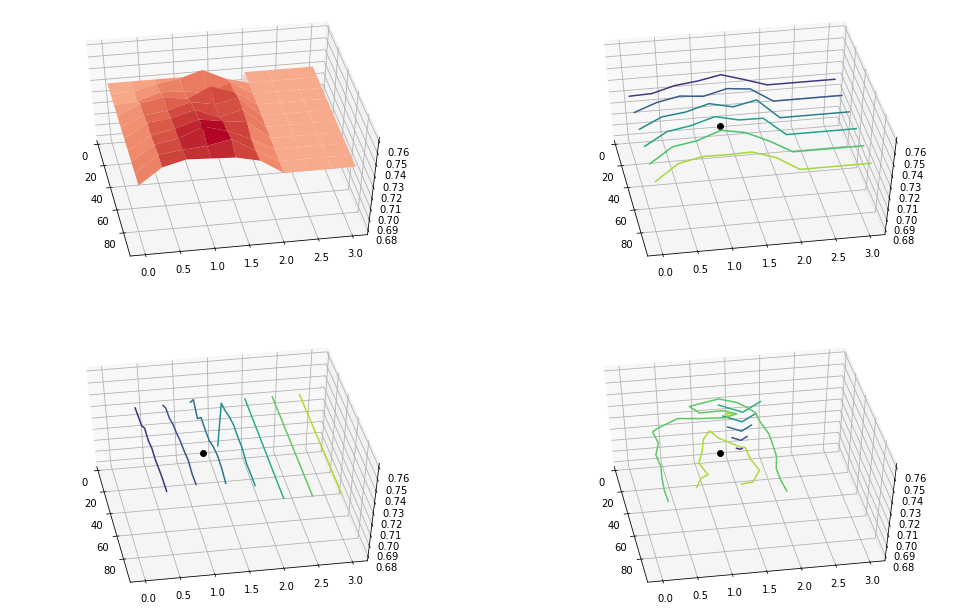

In [1792]:
for angle, angle2 in zip(range(0,360,10), range(0, 360, int(10))):

    fig = plt.figure(figsize=(17,11))
    axs = [fig.add_subplot(2,2,j,projection='3d') for j in [1,2,3,4]]


    axs[0].plot_surface(xi, yi, zi, alpha=1, vmin=zs.min(), cmap='coolwarm')
    
    #axs[1].plot_wireframe(xi, yi, zi, alpha=0.7, cmap='coolwarm')

    axs[1].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='x',
                   offset=None)
    axs[2].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='y',
                   offset=None)
    axs[3].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='z',
                   offset=None)
    
    for i in range(len(top_i)-2):
        [axs[u].scatter([top_i[i][0]], [top_i[i][1]], [top_i[i][2]], marker='o', s=35, color='black', alpha=1) for u in range(4)]
        
    [axs[k].view_init(angle/7, angle) for k in [0,1,2,3]]
    
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)
#    if input()=='exit': break

In [1515]:
cmap = plt.get_cmap('hot')

In [1793]:
cmap = plt.get_cmap('coolwarm')

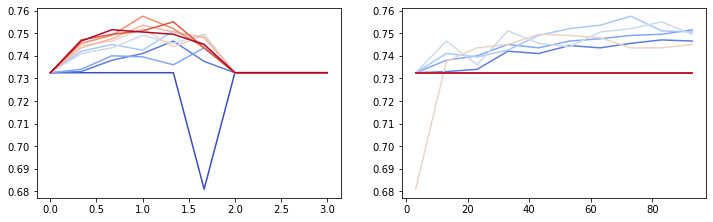

In [1796]:
colors_x = [cmap(j) for j in mms().fit_transform(x_uni.reshape(len(x_uni), 1)).ravel()]
colors_y = [cmap(j) for j in mms().fit_transform(y_uni.reshape(len(y_uni), 1)).ravel()]

fig = plt.figure(figsize=(12,3.5))

axs = [fig.add_subplot(1,2,i) for i in [1,2]]

for i in range(len(x_uni)):
    
    axs[0].plot(yi[i], zi[i], color=colors_x[i], label=x_uni[i])

for k, y_i in enumerate(y_uni):
    
    y_df = top10_tun[top10_tun['learning_rate']==y_i]
    axs[1].plot(y_df['n_estimators'], y_df['acc'], color=colors_y[k])
    
    [axs[o].grid() for o in [0,1]]

plt.show()

# Tuning Size

In [1673]:
len(ano9_prop)==len(ano9_prop_mrg)

True

In [1674]:
n_rows = len(ano9_prop)
bins = 11
degree=3
p_steps = np.linspace(1/bins, 1, bins)**degree
n_times=9
steps =list((p_steps*n_rows).astype(int))*n_times

In [768]:
ano9_prop_shuf = ano9_prop.sample(n_rows)

In [1675]:
ano9_mrg_shuf = ano9_prop_mrg.sample(n_rows)

In [1676]:
params = {i:j for i,j in zip([, 'n_estimators'], [28, 140])}

In [1678]:
params = {'n_estimators':25}

In [1679]:
scrs = []
loop_size = len(steps)
cnt=0
for sample_size in steps:
    
    scr = score_models(ano9_mrg_shuf.iloc[:sample_size], target, [ABC(**params)], ['ETC'], test_size=0.2, random_state=4, retraining=None, clear=False)
    scrs.append(scr)
    clear_output(wait=True)
    
    cnt+=1
    print(cnt, '/', loop_size)

99 / 99


In [1684]:
scrs_df = pd.concat(scrs, axis=0)

In [1685]:
scrs_df.index = steps

[None, None]

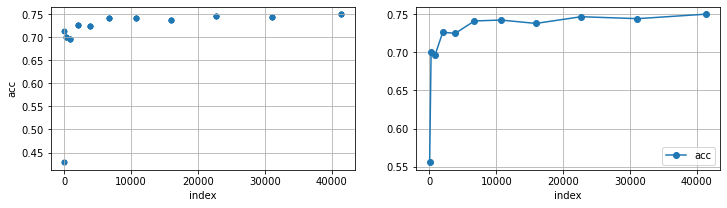

In [1686]:
fig, axs = plt.subplots(1,2,figsize=(12,3))

scrs_df.reset_index().plot.scatter('index', 'acc', ax=axs[0])
scrs_df.reset_index().groupby('index').mean().plot(marker='o', ax=axs[1])

[axs[i].grid() for i in [0,1]]

In [1687]:
scrs_df.reset_index().groupby('index').mean().sort_values('acc', ascending=False).head(5)

,acc
index,
41401,0.750030
22675,0.746637
31105,0.744093
10669,0.742268
6718,0.741071


In [777]:
ano9_lite = ano9_prop_shuf.iloc[:int(0.25*len(ano9_prop))]

In [801]:
ano9_lite.to_csv('quest_aluno_nono_ano_lite.csv', index=False)

In [778]:
len(ano9_lite)

10350

# Tunning Function

In [1049]:
def tune_model(df, target, model, params_dicts, retraining=None, random_state=4, clear=False):
        
    params_names = list(params_dicts[0].keys())
    
    print('Extraindo variáveis alvo e independentes...')
    y = df[target]
    x = df.drop(target, axis=1)
    print('Dividindo amostras de treinamento e de teste...')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

    etc_scrs = []
    loop_size = len(params_dicts)
    cnt=0
    print('{}/{}'.format(cnt, loop_size))
    for params in params_dicts:
        
        params_values = list(params.values())
        
        print('Fitting...')
        new_model = model(**params)
        new_model.fit(x_train, y_train)
        print('Predicting...')
        y_pred = new_model.predict(x_test)
        print('Scoring...')
        acc = acc_scr(y_test, y_pred)
        etc_scrs.append(params_values+[acc])
        
        cnt+=1
        if clear: clear_output(wait=True)
        print('{}/{}'.format(cnt, loop_size), params)

    etc_df = pd.DataFrame(etc_scrs, columns=params_names+['acc'])
    
    if type(retraining)!=type(None):
        etc_df = pd.concat([retraining, etc_df], axis=0)
    return etc_df

# Tuning Individual Parameters

# AdaBoostClassifier

### n Estimators

In [1696]:
params_list = list(range(1,201,20))

In [1697]:
params_dicts = [{'n_estimators':i, 'random_state':15} for i in params_list]

In [1698]:
abc_n_est = tune_model(ano9_lite, target, model=ABC, params_dicts=params_dicts, retraining=None, random_state=4, clear=True)

10/10 {'n_estimators': 181, 'random_state': 15}


In [1699]:
abc_n_est_mrg = tune_model(ano9_mrg_lite, target, model=ABC, params_dicts=params_dicts, retraining=None, random_state=4, clear=True)

10/10 {'n_estimators': 181, 'random_state': 15}


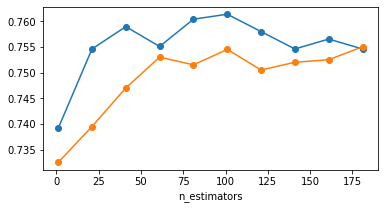

In [1701]:
fig, axs = plt.subplots(1,1,figsize=(6,3))

abc_n_est.set_index('n_estimators')['acc'].plot(marker='o', ax=axs)
abc_n_est_mrg.set_index('n_estimators')['acc'].plot(marker='o', ax=axs)

In [1702]:
n_states=5
state_scrs = []
for random_state in range(n_states):
    abc_n_est_loop = tune_model(ano9_mrg_lite, target, model=ABC, params_dicts=params_dicts, retraining=None, random_state=random_state, clear=True)
    state_scrs.append(abc_n_est_loop)


10/10 {'n_estimators': 181, 'random_state': 15}


In [1708]:
n_states=5
state_scrs = []
for random_state in range(n_states):
    abc_n_est_loop_padrao = tune_model(ano9_lite, target, model=ABC, params_dicts=params_dicts, retraining=None, random_state=random_state, clear=True)
    state_scrs.append(abc_n_est_loop_padrao)


10/10 {'n_estimators': 181, 'random_state': 15}


### random_state=15

In [1703]:
cmap = plt.get_cmap()

In [1704]:
colors = [cmap(i) for i in np.linspace(0,1,5)]

In [823]:
colors = ['lightblue', 'darkblue', 'red', 'green', 'yellow', 'brown']

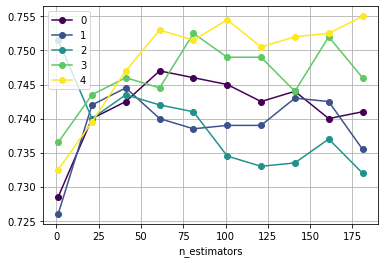

In [1705]:
fig, axs = plt.subplots()

for i in range(5):
    state_scrs[i].plot('n_estimators', 'acc', ax=axs, color=colors[i], marker='o', label=i)
    plt.grid()

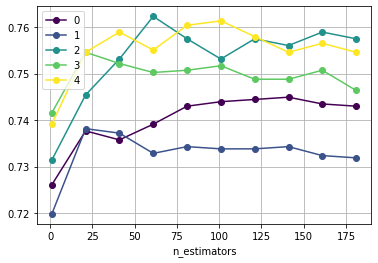

In [1709]:
fig, axs = plt.subplots()

for i in range(5):
    state_scrs[i].plot('n_estimators', 'acc', ax=axs, color=colors[i], marker='o', label=i)
    plt.grid()

## Learning Rate

In [1710]:
params_list = np.linspace(0.001,2,25)

params_dicts = [{'learning_rate':i, 'random_state':None} for i in params_list]

### Single Model

In [ ]:
abc_lr = tune_model(ano9_lite, target, model=ABC, params_dicts=params_dicts, retraining=None, random_state=14, clear=True)

### Multiple Random States

In [ ]:
n_states=15
state_scrs = []
cnt=0
for random_state in range(n_states):
    abc_lr = tune_model(ano9_mrg_lite, target, model=ABC, params_dicts=params_dicts, retraining=None, random_state=random_state, clear=True)
    state_scrs.append(abc_lr)
    
    cnt+=1
    clear_output(wait=True)
    print(cnt,'/',n_states)


In [1150]:
stt_scr_avg = pd.concat([state_scrs[i] for i in range(len(state_scrs))], axis=0)

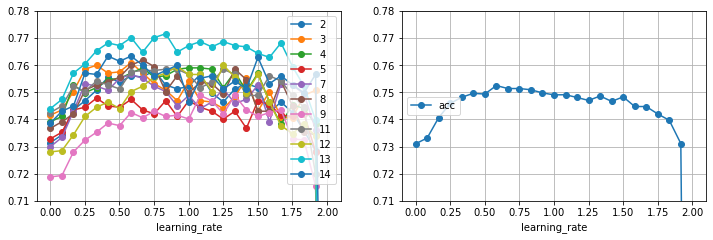

In [1180]:
fig, axs = plt.subplots(1,2,figsize=(12,3.5))

top_n_est = []
for i in range(15):
    if state_scrs[i]['acc'].iloc[4:].mean()>0.72:
        state_scrs[i].plot('learning_rate', 'acc', ax=axs[0], marker='o', label=i)
        top_n_est.append(i)
        
stt_scr_avg.groupby('learning_rate').mean().plot(marker='o', ylim=(0.72,0.76), ax=axs[1])

[axs[j].set_ylim(0.71, 0.78) for j in [0,1]]
plt.legend(loc='center left')
[axs[j].grid() for j in [0,1]]

plt.show()

# IDEA: TUNAR DIFERENTES ESTADOS ALEATORIOS E PLOTAR NO MESMO GRAFICO AS DIFERENTES SUPERFICIES

# Tuning n_estimators: ABC

In [986]:
params_list = np.ravel([[i]*1 for i in range(1,161,10)])

In [987]:
params_dicts = [{'n_estimators':i, 'random_state':15} for i in params_list]

In [988]:
n_states=25
state_scrs = []
for random_state in range(n_states):
    abc_n_est = tune_model(ano9_lite, target, model=ABC, params_dicts=params_dicts, retraining=None, random_state=random_state)
    state_scrs.append(abc_n_est)


16/16 {'n_estimators': 151, 'random_state': 15}


### random_state=15

In [996]:
np.random.rand(3)

array([0.56970263, 0.82162294, 0.04120702])

In [1006]:
import matplotlib.colors as colors

In [1002]:
colors = [np.random.random() for i in range(30)]

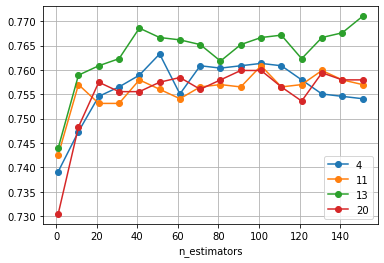

In [1021]:
fig, axs = plt.subplots()

top_n_est = []
for i in range(25):
    if state_scrs[i]['acc'].iloc[4:].mean()>0.757:
        state_scrs[i].plot('n_estimators', 'acc', ax=axs, marker='o', label=i)
        top_n_est.append(i)
        
plt.grid()

In [1022]:
top_n_est

[4, 11, 13, 20]

# Tuning Max_Depth: ETC

In [202]:
params_list = sorted(list(range(1,51,5))*7)

In [203]:
etc_max_depth = tune_etc(ano9_prop, target, param_name='max_depth', retraining=None, params_list=params_list)

70/70 {'max_depth': 46}


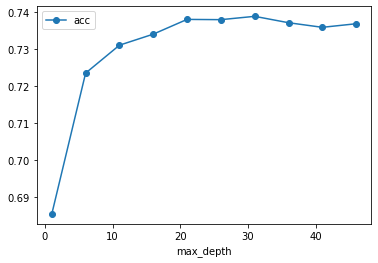

In [205]:
etc_max_depth.groupby('max_depth').mean().plot(marker='o')

In [203]:
etc_max_depth = tune_etc(ano9_prop, target, param_name='max_depth', retraining=None, params_list=params_list)

70/70 {'max_depth': 46}


# Tuning 'max_leaf_nodes'

In [430]:
top_acc

,n_estimators,max_depth,acc
126,140,28,0.745562
135,145,25,0.744596
79,115,37,0.744355
127,140,31,0.744234
36,95,28,0.743872
77,115,31,0.743751


# Tunning ABD: n_estimators and learning_rate

In [1809]:
n_estimators = np.arange(25, 225, 10)
learning_rate = np.linspace(0.001, 2.5, 20)

comb_params_abc = [{'n_estimators':i, 'learning_rate':j, 'random_state':1} for i,j in list(itertools.product(n_estimators, learning_rate))]*7

print('Nº de iterações (combinação de paramentros): ', len(comb_params_abc))

Nº de iterações (combinação de paramentros):  2800


### Grid Search

In [1811]:
abc_comb = tune_model(ano9_mrg_lite, target, model=ABC, params_dicts=comb_params_abc, retraining=None, random_state=1, clear=True)

2800/2800 {'n_estimators': 215, 'learning_rate': 2.5, 'random_state': 1}


### 3D Optmization

In [1631]:
xs, ys, zs = [abc_comb.iloc[:, i] for i in [0,1,3]] 

top_acc = abc_comb.sort_values(by='acc', ascending=False).head(3)

cols = ['n_estimators', 'learning_rate', 'acc']
top_i = [[top_acc[col].iloc[i] for col in cols] for i in range(3)]

x_uni = xs.unique()
y_uni = ys.unique()

yi, xi = np.meshgrid(ys.unique(), xs.unique())
zi = np.array(zs).reshape(len(x_uni), int(len(zs) / len(x_uni)))


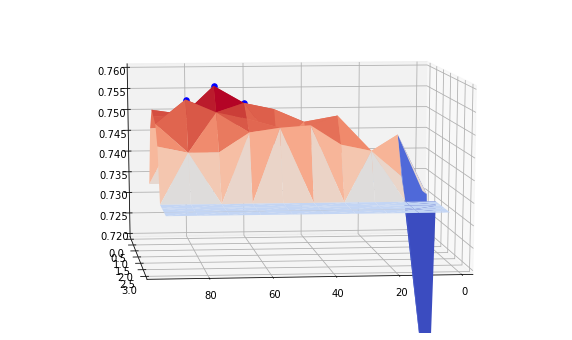

In [1802]:
#for angle, angle2 in zip(range(1,721,10), list(np.zeros(36)) + list(range(0,90,int(90/36)))):
for angle, angle2 in zip(range(0,90,6), range(0, 360, 6)):

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1,projection='3d')

    ax.plot_trisurf(xs, ys, zs, alpha=1, cmap='coolwarm', vmin=zs.max()-0.04)
    
    for i in range(len(top_i)):
        ax.scatter([top_i[i][0]], [top_i[i][1]], [top_i[i][2]], marker='o', s=30, color='blue')
    
    ax.view_init(angle2/8, angle)
    
    ax.set_zlim(0.72,0.76)
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)
    

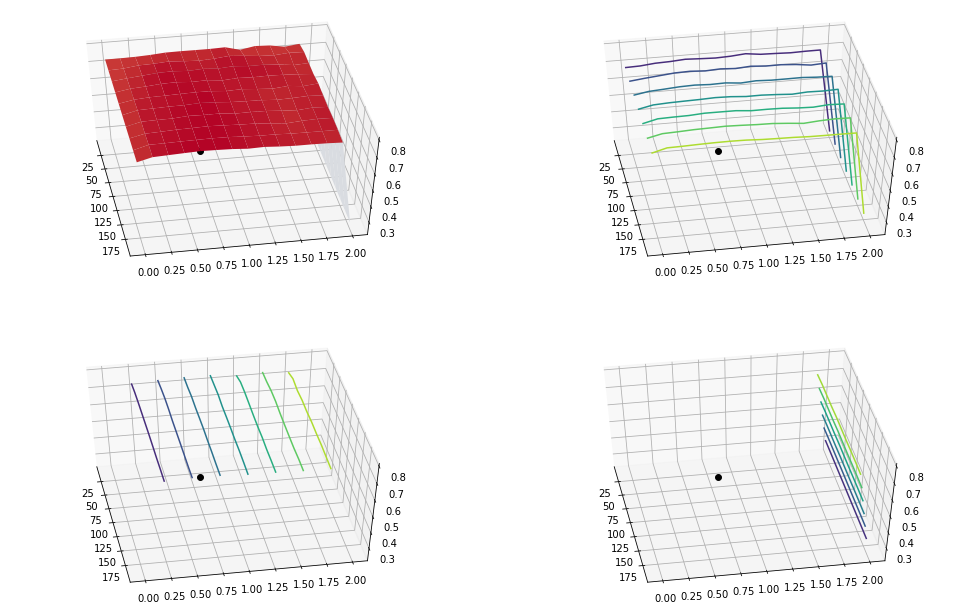

In [1633]:
for angle, angle2 in zip(range(0,360,10), range(0, 360, int(10))):

    fig = plt.figure(figsize=(17,11))
    axs = [fig.add_subplot(2,2,j,projection='3d') for j in [1,2,3,4]]


    axs[0].plot_surface(xi, yi, zi, alpha=1, vmin=zs.min(), cmap='coolwarm')
    
    #axs[1].plot_wireframe(xi, yi, zi, alpha=0.7, cmap='coolwarm')

    axs[1].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='x',
                   offset=None)
    axs[2].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='y',
                   offset=None)
    axs[3].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='z',
                   offset=None)
    
    for i in range(len(top_i)-2):
        [axs[u].scatter([top_i[i][0]], [top_i[i][1]], [top_i[i][2]], marker='o', s=35, color='black', alpha=1) for u in range(4)]
        
    [axs[k].view_init(angle/7, angle) for k in [0,1,2,3]]
    
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)
#    if input()=='exit': break

In [1515]:
cmap = plt.get_cmap('hot')

In [1634]:
cmap = plt.get_cmap('coolwarm')

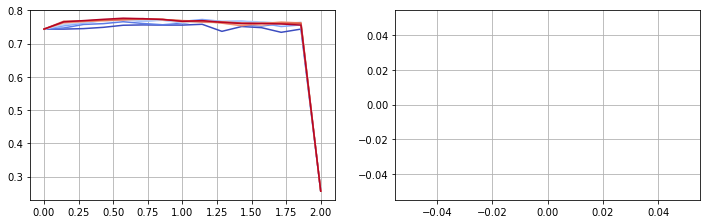

In [1635]:
colors_x = [cmap(j) for j in mms().fit_transform(x_uni.reshape(len(x_uni), 1)).ravel()]
colors_y = [cmap(j) for j in mms().fit_transform(y_uni.reshape(len(y_uni), 1)).ravel()]

fig = plt.figure(figsize=(12,3.5))

axs = [fig.add_subplot(1,2,i) for i in [1,2]]

for i in range(len(x_uni)):
    
    axs[0].plot(yi[i], zi[i], color=colors_x[i], label=x_uni[i])

for k, y_i in enumerate(y_uni):
    
    y_df = etc_comb[etc_comb['max_depth']==y_i]
    axs[1].plot(y_df['n_estimators'], y_df['acc'], color=colors_y[k])
    
    [axs[o].grid() for o in [0,1]]

plt.show()

# Tunando Parametros: Extra Trees Classifier

In [308]:
import itertools

In [1589]:
n_estimators = np.array(range(20,241,30))
max_depth = np.array(range(1,50,3))

n_times = 1 # vezes para tirar a media e amaciar a superficie

comb_params = [{'n_estimators':i, 'max_depth':j, 'random_state':random_state} for i,j in list(itertools.product(n_estimators, max_depth)) for random_state in range(7,8)]*n_times

len(comb_params)

136

In [1590]:
len(ano9_lite)

10350

In [1592]:
etc_comb = tune_model(ano9_lite, target, params_dicts=comb_params, retraining=None, model=ETC, clear=True, random_state=13)

136/136 {'n_estimators': 230, 'max_depth': 49, 'random_state': 7}


In [1355]:
#etc_comb.to_csv('ETC_tune_5265iters_15times.csv', index=False)

### Setting 3D Plot

In [1595]:
etc_comb_orig = etc_comb.copy()

In [1596]:
etc_comb = etc_comb_orig

In [1369]:
etc_comb = etc_comb_orig.groupby(['n_estimators', 'max_depth']).mean().reset_index()

In [1616]:
xs, ys, zs = [etc_comb.iloc[:, i] for i in [0,1,3]] 

top_acc = etc_comb.sort_values(by='acc', ascending=False).head(3)

cols = ['n_estimators', 'max_depth', 'acc']
top_i = [[top_acc[col].iloc[i] for col in cols] for i in range(3)]

x_uni = xs.unique()
y_uni = ys.unique()

yi, xi = np.meshgrid(ys.unique(), xs.unique())
zi = np.array(zs).reshape(len(x_uni), int(len(zs) / len(x_uni)))


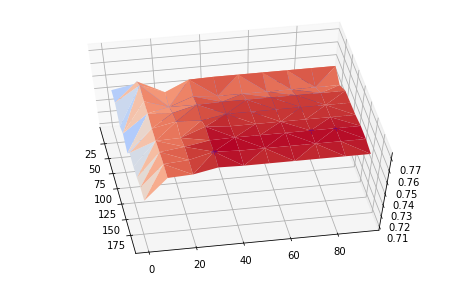

In [1617]:
#for angle, angle2 in zip(range(1,721,10), list(np.zeros(36)) + list(range(0,90,int(90/36)))):
for angle, angle2 in zip(range(0,360,10), range(0, 360, int(10))):

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1,projection='3d')

    ax.plot_trisurf(xs, ys, zs, alpha=1, cmap='coolwarm', vmin=zs.max()-0.04)
    
    for i in range(len(top_i)):
        ax.scatter([top_i[i][0]], [top_i[i][1]], [top_i[i][2]], marker='o', s=30, color='blue')
    
    ax.view_init(angle2/6, angle)
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)

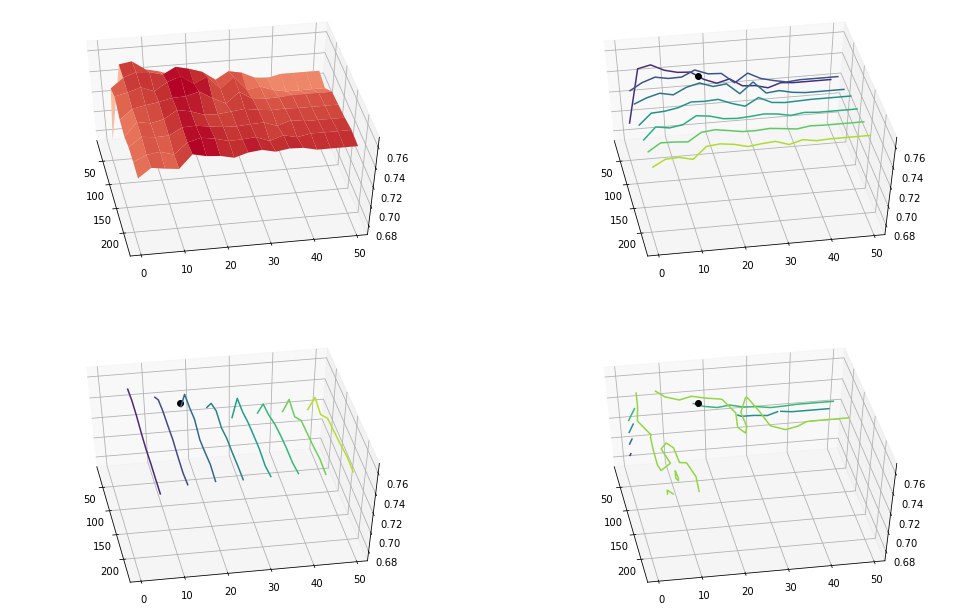

In [1600]:
for angle, angle2 in zip(range(0,360,10), range(0, 360, int(10))):

    fig = plt.figure(figsize=(17,11))
    axs = [fig.add_subplot(2,2,j,projection='3d') for j in [1,2,3,4]]


    axs[0].plot_surface(xi, yi, zi, alpha=1, vmin=zs.min(), cmap='coolwarm')
    
    #axs[1].plot_wireframe(xi, yi, zi, alpha=0.7, cmap='coolwarm')

    axs[1].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='x',
                   offset=None)
    axs[2].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='y',
                   offset=None)
    axs[3].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='z',
                   offset=None)
    
    for i in range(len(top_i)-2):
        [axs[u].scatter([top_i[i][0]], [top_i[i][1]], [top_i[i][2]], marker='o', s=35, color='black', alpha=1) for u in range(4)]
        
    [axs[k].view_init(angle/7, angle) for k in [0,1,2,3]]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)
#    if input()=='exit': break

In [1515]:
cmap = plt.get_cmap('hot')

In [1584]:
cmap = plt.get_cmap('coolwarm')

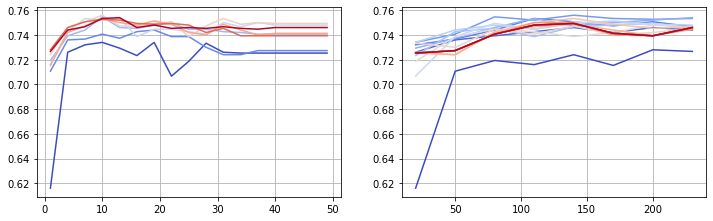

In [1585]:
colors_x = [cmap(j) for j in mms().fit_transform(x_uni.reshape(len(x_uni), 1)).ravel()]
colors_y = [cmap(j) for j in mms().fit_transform(y_uni.reshape(len(y_uni), 1)).ravel()]

fig = plt.figure(figsize=(12,3.5))

axs = [fig.add_subplot(1,2,i) for i in [1,2]]

for i in range(len(x_uni)):
    
    axs[0].plot(yi[i], zi[i], color=colors_x[i], label=x_uni[i])

for k, y_i in enumerate(y_uni):
    
    y_df = etc_comb[etc_comb['max_depth']==y_i]
    axs[1].plot(y_df['n_estimators'], y_df['acc'], color=colors_y[k])
    
    [axs[o].grid() for o in [0,1]]

plt.show()

# Tunando RFC

In [1602]:
n_estimators = np.array(range(10,201,20))
max_depth = np.array(range(1,100,10))

n_times = 1 # vezes para tirar a media e amaciar a superficie

comb_params = [{'n_estimators':i, 'max_depth':j, 'random_state':15} for i,j in list(itertools.product(n_estimators, max_depth))]*n_times

len(comb_params)

100

In [1603]:
rfc_comb = tune_model(ano9_lite, target, params_dicts=comb_params, retraining=None, model=RFC, clear=True, random_state=13)

100/100 {'n_estimators': 190, 'max_depth': 91, 'random_state': 15}


### Setting 3D Plot

In [1605]:
rfc_comb_orig = rfc_comb.copy()

In [1610]:
rfc_comb = rfc_comb_orig

In [70]:
rfc_comb = rfc_comb_orig.groupby(['n_estimators', 'max_depth']).mean().reset_index()

In [1611]:
xs, ys, zs = [rfc_comb.iloc[:, i] for i in [0,1,3]] 

top_acc = rfc_comb.sort_values(by='acc', ascending=False).head(3)

cols = ['n_estimators', 'max_depth', 'acc']
top_i = [[top_acc[col].iloc[i] for col in cols] for i in range(3)]

x_uni = xs.unique()
y_uni = ys.unique()

yi, xi = np.meshgrid(ys.unique(), xs.unique())
zi = np.array(zs).reshape(len(x_uni), int(len(zs) / len(x_uni)))


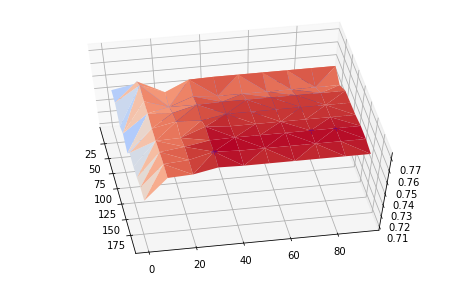

In [1612]:
#for angle, angle2 in zip(range(1,721,10), list(np.zeros(36)) + list(range(0,90,int(90/36)))):
for angle, angle2 in zip(range(0,360,10), range(0, 360, int(10))):

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1,projection='3d')

    ax.plot_trisurf(xs, ys, zs, alpha=1, cmap='coolwarm', vmin=zs.max()-0.04)
    
    for i in range(len(top_i)):
        ax.scatter([top_i[i][0]], [top_i[i][1]], [top_i[i][2]], marker='o', s=30, color='blue')
    
    ax.view_init(angle2/6, angle)
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)

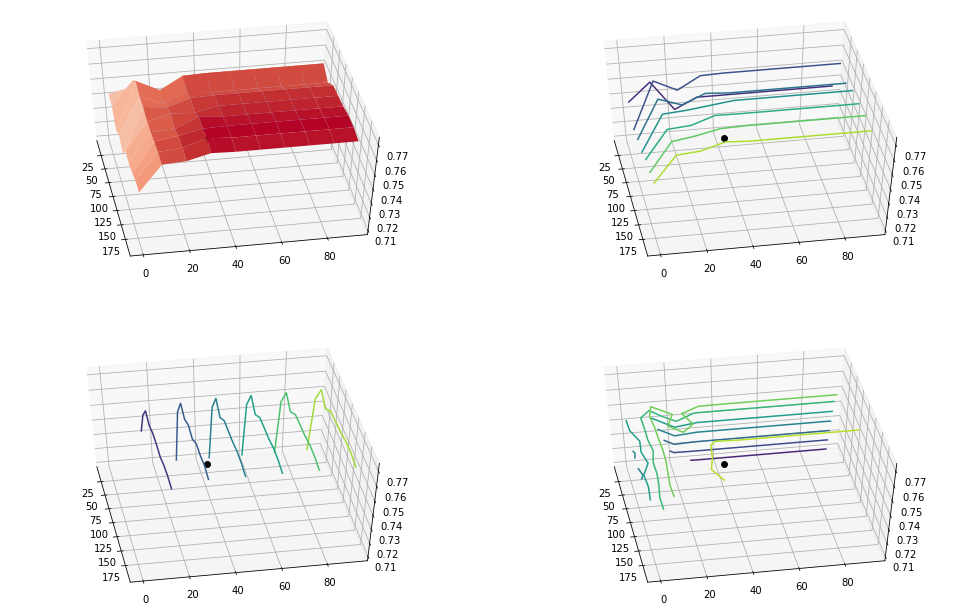

In [1613]:
for angle, angle2 in zip(range(0,360,10), range(0, 360, int(10))):

    fig = plt.figure(figsize=(17,11))
    axs = [fig.add_subplot(2,2,j,projection='3d') for j in [1,2,3,4]]


    axs[0].plot_surface(xi, yi, zi, alpha=1, vmin=zs.min(), cmap='coolwarm')
    
    #axs[1].plot_wireframe(xi, yi, zi, alpha=0.7, cmap='coolwarm')

    axs[1].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='x',
                   offset=None)
    axs[2].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='y',
                   offset=None)
    axs[3].contour(xi, yi, zi, alpha=1, 
                   extend3d=False,
                   stride=1,
                   zdir='z',
                   offset=None)
    
    for i in range(len(top_i)-2):
        [axs[u].scatter([top_i[i][0]], [top_i[i][1]], [top_i[i][2]], marker='o', s=35, color='black', alpha=1) for u in range(4)]
        
    [axs[k].view_init(angle/7, angle) for k in [0,1,2,3]]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)
#    if input()=='exit': break

In [1515]:
cmap = plt.get_cmap('hot')

In [1614]:
cmap = plt.get_cmap('coolwarm')

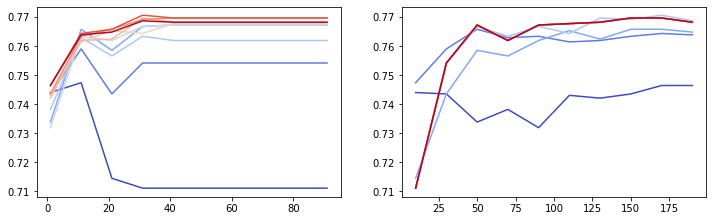

In [1615]:
colors_x = [cmap(j) for j in mms().fit_transform(x_uni.reshape(len(x_uni), 1)).ravel()]
colors_y = [cmap(j) for j in mms().fit_transform(y_uni.reshape(len(y_uni), 1)).ravel()]

fig = plt.figure(figsize=(12,3.5))

axs = [fig.add_subplot(1,2,i) for i in [1,2]]

for i in range(len(x_uni)):
    
    axs[0].plot(yi[i], zi[i], color=colors_x[i], label=x_uni[i])

for k, y_i in enumerate(y_uni):
    
    y_df = etc_comb[etc_comb['max_depth']==y_i]
    axs[1].plot(y_df['n_estimators'], y_df['acc'], color=colors_y[k])
    
    [axs[o].grid() for o in [0,1]]

plt.show()

### Categorical Plotting

In [72]:
Q_columns = ano3.columns[15:]

In [79]:
ano9_prop[Q_columns[:3]]

,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003
0,0,2,8
1,1,1,8
2,0,1,5
3,1,1,11
4,0,0,7
...,...,...,...
41396,0,3,11
41397,0,0,8
41398,0,0,5
41399,1,1,4


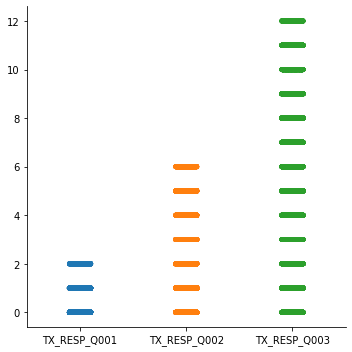

In [78]:
sns.catplot(data=ano9_prop[Q_columns[:3]])